In [1]:
%load_ext autoreload
%autoreload 2
import config as cfg
from sca import plots, helpers as h

In [4]:
X, y, pts, ks = h.load_data("data/raw/ascadv.h5", as_df=True)

Wykres outlierów (sigma > 4):

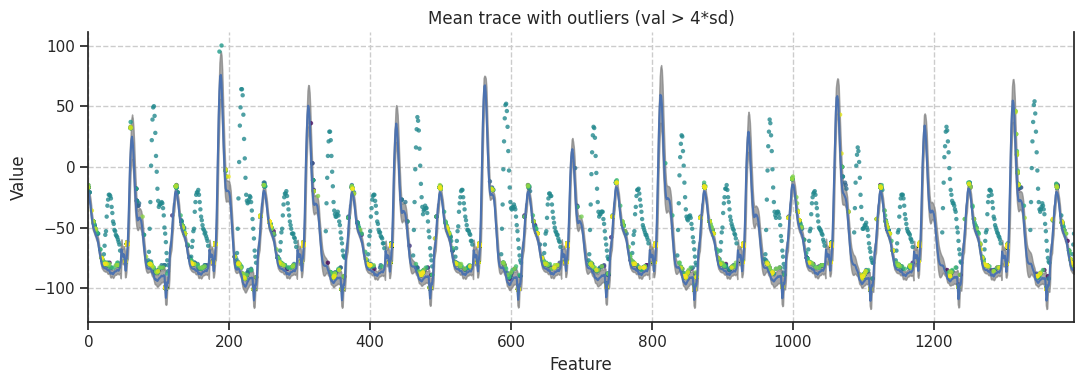

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style='ticks')

def plot_trace_outliers(X):
    fig, ax = plt.subplots(figsize=(11, 4))
    
    m, sd = plots.mean_std(X)
    ax.plot(m, label="mean")
    plots.std_band(ax, m, sd)
    ax.grid(True, linestyle='--')

    ox, oy = np.where(X - m > 4 * sd)

    cmap = sns.color_palette('viridis', as_cmap=True)
    norm = plt.Normalize(ox.min(), ox.max())
    colors = cmap(norm(ox))

    ax.scatter(oy, X.values[ox, oy], c=colors, s=10, linewidths=0, alpha=0.8)
    
    plots.lim(ax, len(m))
    plots.labs(ax, xlab="Feature", ylab="Value",
               title="Mean trace with outliers (val > 4*sd)")

    fig.tight_layout()
    sns.despine(ax=ax, right=False)
    return fig, ax
    
fig, _ = plot_trace_outliers(X)
fig.savefig("figures/mean_trace_outliers.svg")

In [6]:
import pandas as pd
m, sd = plots.mean_std(X.values)
Z = (X.values - m) / sd
trace, feat = np.where(Z > 4)

df_z = pd.DataFrame({"Trace": trace, "Feature": feat, "Z-score": Z[trace, feat]})
df_z.sort_values("Z-score", ascending=False, inplace=True)

bins = [4, 5, 7, 10, np.inf]
labels = ["4–5σ", "5–6σ", "7–10σ", ">10σ"]

df_z["Bin"] = pd.cut(df_z["Z-score"], bins=bins, labels=labels, right=True)

df_feat = (
    df_z.groupby(["Trace", "Bin"], observed=False)
    .size().unstack(fill_value=0).reset_index()
)

df_feat["Total"] = df_feat[labels].sum(axis=1)
df_feat = df_feat.sort_values("Total", ascending=False)
df_feat = df_feat[df_feat["Total"] >= 20]

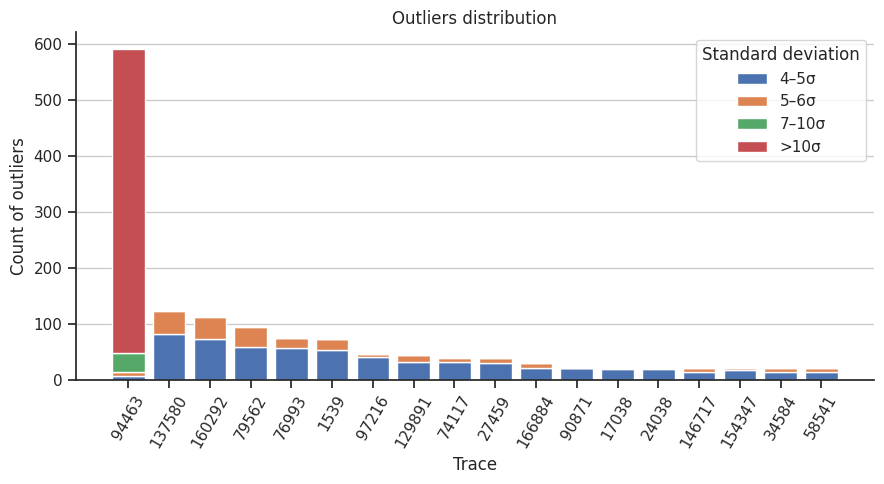

In [7]:
fig, ax = plt.subplots(figsize=(9, 5))

x = np.arange(len(df_feat["Trace"]))
bottom = np.zeros(len(df_feat))

for c in labels:
    ax.bar(x, df_feat[c], bottom=bottom, label=c)
    bottom += df_feat[c].to_numpy()

ax.set_xlabel("Trace")
ax.set_ylabel("Count of outliers")
ax.set_title(f"Outliers distribution")
ax.set_xticks(x)
ax.set_xticklabels(df_feat["Trace"], rotation=60)

ax.legend(title="Standard deviation")
ax.grid(axis="y")

sns.despine(ax=ax)
fig.tight_layout()
fig.savefig("figures/feature_anomalies.svg")

Próbka 94463 jest ewidentnie błędna, więc zostanie usunięta. Pozostałe mimo długich "ogonów" wyglądają sensownie.

In [8]:
h.save_data(
    cfg.DATA_DIR / "ascadv_clean.h5",
    X.drop(index=94463),
    y.drop(index=94463),
    pts.drop(index=94463),
    ks.drop(index=94463),
)

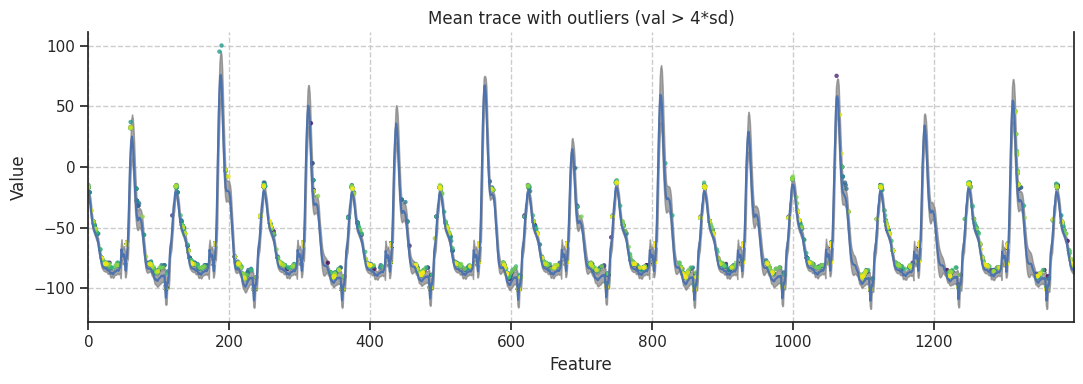

In [7]:
X, y, pts, ks = h.load_data(DATA_DIR / "ascadv_clean.h5", as_df=True)
fig, _ = plot_trace_outliers(X)
fig.savefig("figures/mean_trace_outliers_clean.svg")

In [10]:
import config as cfg
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sca import helpers as h

pl_rf = make_pipeline(
    StandardScaler(),
    RFC(
        n_estimators=100, max_depth=10, 
        min_samples_leaf=10, n_jobs=-1,
        random_state=cfg.SEED
    )
)

X, y, pts, ks = h.load_data(cfg.DATA_DIR / "ascadv_clean.h5")

fi, feat_rank = h.feature_importances(pl_rf, X, y, pts, ks, seed=cfg.SEED)
res = h.n_feats_search(pl_rf, X, y, pts, ks, feat_rank, 
                       [100, 150, 175, 200, 225, 250], seed=cfg.SEED)
res

KeyboardInterrupt: 